# Method 4 — Cohere multimodal embeddings + FAISS + answer with citations


Update `PDF_PATH` and run top-to-bottom.

Artifacts saved under `ARTIFACTS_DIR`:
- extracted images in `artifacts/images/`
- metadata JSON in `artifacts/`
- FAISS indexes in `artifacts/`

<!-- ## Install

```bash
pip install pymupdf pillow faiss-cpu tqdm cohere openai
``` -->


In [1]:
from doc_image_retrieval_utils import *

PDF_PATH = "Internationalisation_of_Higher_Education_in_India_Report_chapter_2.pdf"  # <-- change me
ARTIFACTS_DIR = "artifacts"

text_chunks, image_records = load_pdf_extract_text_and_images(PDF_PATH, artifacts_dir=ARTIFACTS_DIR)
save_metadata(text_chunks, image_records, artifacts_dir=ARTIFACTS_DIR)

print("Text chunks:", len(text_chunks))
print("Images:", len(image_records))
if image_records:
    print("Example image:", image_records[0])


Text chunks: 73
Images: 8
Example image: ImageRecord(image_id='p2_img1', page=2, image_path='artifacts\\images\\p2_img1.jpeg')


## Cohere multimodal embeddings (`embed-v4.0`) + FAISS

In [2]:
from doc_image_retrieval_utils import *
import faiss, os

# Use the SAME multimodal model for text + image so text queries can retrieve images well.
text_vecs = cohere_embed_texts([c.text for c in text_chunks], model="embed-v4.0", input_type="search_document")
img_vecs  = cohere_embed_images([r.image_path for r in image_records], model="embed-v4.0", input_type="search_document")

text_index = build_faiss_ip_index(l2_normalize(text_vecs))
img_index  = build_faiss_ip_index(l2_normalize(img_vecs))

faiss.write_index(text_index, os.path.join(ARTIFACTS_DIR, "faiss_cohere_text.index"))
faiss.write_index(img_index,  os.path.join(ARTIFACTS_DIR, "faiss_cohere_images.index"))
print("Saved FAISS indexes.")


Saved FAISS indexes.


## 6) Inference: text query → answer (citations) + images

India's strategies in the education system, particularly in the context of internationalisation, include:

1. **Blending Global Best Practices**: India has the opportunity to shape its internationalisation strategy by integrating global educational best practices with its own intellectual and cultural strengths, particularly in technical and professional education [p13_c2].

2. **Cost-Effective Education**: Leveraging its cost advantage and English-medium instruction, India appeals to students from the Global South, aiming to attract more international students [p13_c2]. The **Study in India Programme** launched in 2018 further emphasizes this initiative to strengthen inbound student mobility, positioning Indian higher education institutions (HEIs) as attractive alternatives to traditional destinations [p14_c2].

3. **Utilisation of Indian Knowledge System (IKS)**: Incorporating IKS into curricula can provide globally relevant interdisciplinary insights, enabling India to contribute un

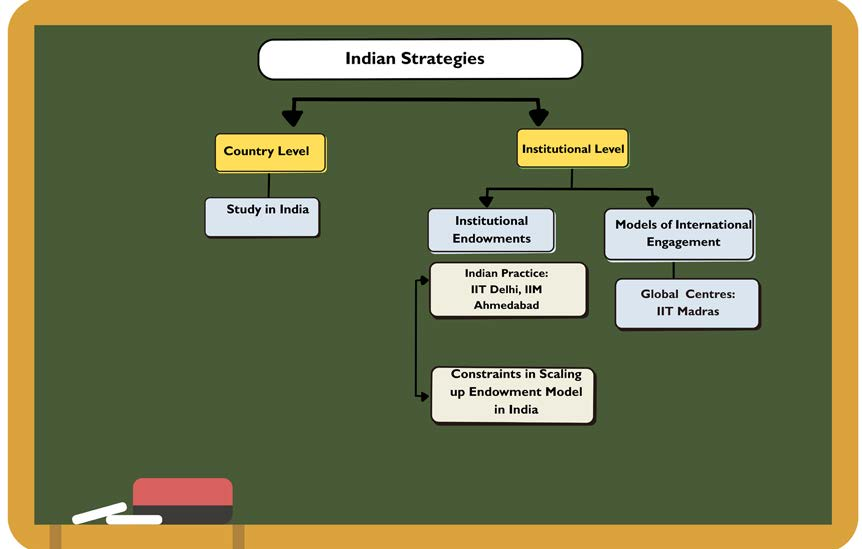

p13_img1 (page 13) score=0.263 -> artifacts\images\p13_img1.jpeg


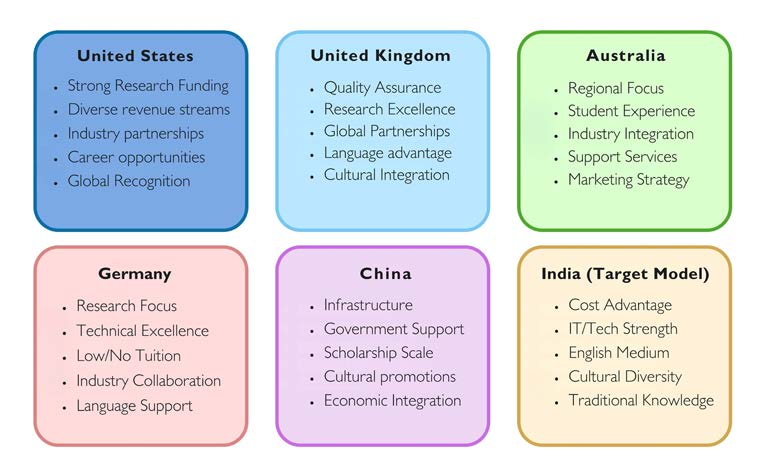

p2_img1 (page 2) score=0.247 -> artifacts\images\p2_img1.jpeg


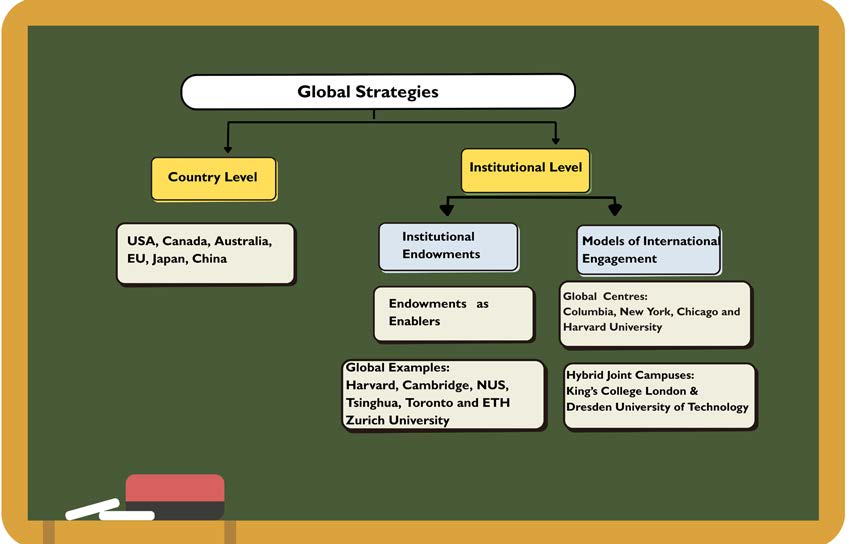

p16_img1 (page 16) score=0.150 -> artifacts\images\p16_img1.jpeg


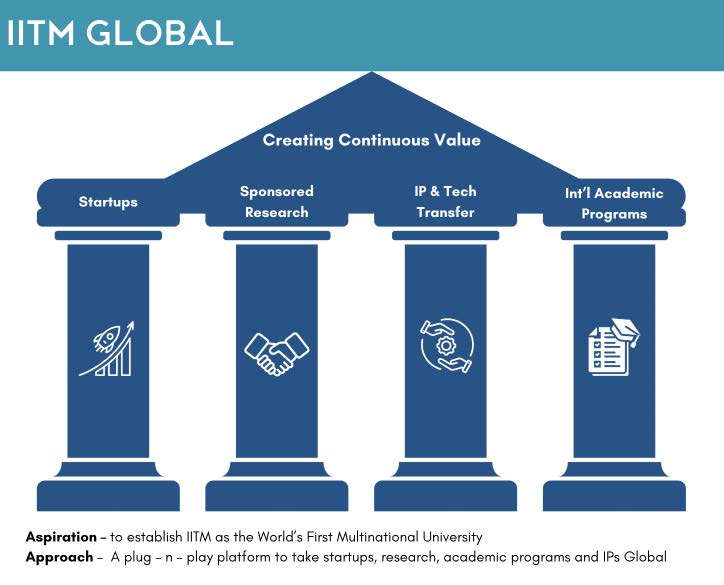

In [3]:
from doc_image_retrieval_utils import *
import faiss, os

text_index = faiss.read_index(os.path.join(ARTIFACTS_DIR, "faiss_cohere_text.index"))
img_index  = faiss.read_index(os.path.join(ARTIFACTS_DIR, "faiss_cohere_images.index"))

def retrieve_text(query: str, top_k: int = 8):
    q = l2_normalize(cohere_embed_texts([query], model="embed-v4.0", input_type="search_query"))
    scores, idxs = faiss_search(text_index, q, top_k)
    return [(text_chunks[i], float(scores[j])) for j, i in enumerate(idxs)]

def retrieve_images(query: str, top_k: int = 6):
    q = l2_normalize(cohere_embed_texts([query], model="embed-v4.0", input_type="search_query"))
    scores, idxs = faiss_search(img_index, q, top_k)
    return [(image_records[i], float(scores[j])) for j, i in enumerate(idxs)]

QUERY = "What are the indian strategies in education system "
text_hits = retrieve_text(QUERY, top_k=10)
img_hits  = retrieve_images(QUERY, top_k=6)

print(answer_with_citations(QUERY, text_hits))
print("\nTop images:")
show_images(img_hits, max_show=4)
